In [34]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
from pathlib import Path

import os
import zarr
import h5py
import dotenv
import scipy.ndimage
import nibabel as nib
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from tqdm import tqdm
dotenv.load_dotenv()

from experiments.gradcam_mean import average, zoom_heatmap

## Volume

In [36]:
DATA = Path(os.getenv('DATA'))
CONFIG = Path(os.getenv('CONFIG'))
out_dir = DATA/'nako/processed/volume'
cfg = OmegaConf.load(str(CONFIG/'volume/config.yaml'))
store = zarr.DirectoryStore(str(out_dir/'maps.zarr'))
info = pd.read_csv(cfg.dataset.info).astype({'key': str, 'age': np.float64})
h5_path = cfg.dataset.data
volume_predictions = pd.read_feather(DATA/'nako/processed/volume/predictions.feather').astype({'key': str})
df = info.join(volume_predictions.set_index('key'), on='key', how='inner')

In [37]:
hmap_average_mean = {'aa': None, 'am': None, 'af': None,
                     'ym': None, 'mm': None, 'om': None, 
                     'yf': None, 'mf': None, 'of': None}
hmap_mean_zoomed = {'aa': None, 'am': None, 'af': None,
                    'ym': None, 'mm': None, 'om': None, 
                    'yf': None, 'mf': None, 'of': None}
img = {'aa': None, 'am': None, 'af': None,
       'ym': None, 'mm': None, 'om': None, 
       'yf': None, 'mf': None, 'of': None}
with zarr.open(store=store, mode='a') as zf:
    for cat in list(img):
        img[cat] = zf[f'average/image/{cat}'][:]
        hmap_average_mean[cat] = zf[f'average/heatmap_mean/{cat}'][:]
        hmap_mean_zoomed[cat] = zoom_heatmap(hmap_average_mean[cat], img[cat].shape, order=3)

In [38]:
# export results to nifti
#for c in list(img):
#    nii = nib.Nifti1Image(img[c], affine)
#    nib.save(nii, DATA/f'nako/processed/volume/export/img_{c}.nii.gz')
#    nii = nib.Nifti1Image(hmap_mean_zoomed[c], affine)
#    nib.save(nii, DATA/f'nako/processed/volume/export/hmap_mean_zoomed_{c}.nii.gz')

(100, 125, 105)


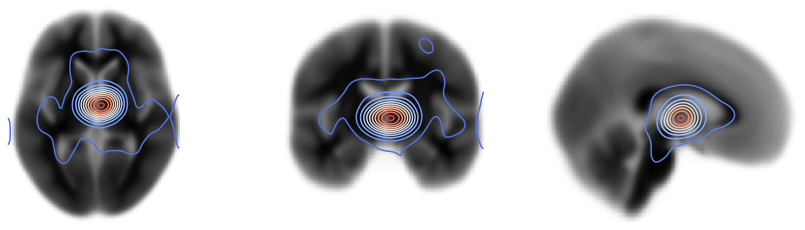

In [70]:
c = 'aa'
# set relative threshold
th = 0.6*hmap_mean_zoomed[c].max()
print(img[c].shape)
fig = plt.figure(figsize=(4, 3))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(np.rot90(1-img[c][:,:,50]), cmap='gray')
hmap = hmap_mean_zoomed[c][:,:,50]
hmap_masked = np.ma.array(hmap, mask=hmap<th)
#ax.imshow(np.rot90(hmap_masked), cmap='coolwarm', alpha=0.4)
ax.contour(np.rot90(hmap), levels=10,cmap='coolwarm')
ax = fig.add_axes([1, 0, 1, 1])
ax.axis('off')
ax.imshow(np.rot90(1-img[c][:,67,:]), cmap='gray')
hmap = hmap_mean_zoomed[c][:,67,:]
hmap_masked = np.ma.array(hmap, mask=hmap<th)
#ax.imshow(np.rot90(hmap_masked), cmap='coolwarm', alpha=0.4)
ax.contour(np.rot90(hmap), levels=10, cmap='coolwarm')
ax = fig.add_axes([2, 0, 1, 1])
ax.axis('off')
ax.imshow(np.rot90(1-img[c][50,:,:]), cmap='gray')
hmap = hmap_mean_zoomed[c][50,:,:]
hmap_masked = np.ma.array(hmap, mask=hmap<th)
#ax.imshow(np.rot90(hmap_masked), cmap='coolwarm', alpha=0.4)
ax.contour(np.rot90(hmap), n=10, cmap='coolwarm')
plt.savefig('Figure3.pdf', dpi=600, transparent=False, bbox_inches='tight')


## Patchwise

In [71]:
DATA = Path(os.getenv('DATA'))
CONFIG = Path(os.getenv('CONFIG'))
out_dir = DATA/'nako/processed/patchwise'
cfg = OmegaConf.load(str(CONFIG/'volume/config.yaml'))
store = zarr.DirectoryStore(str(out_dir/'patches.zarr'))
position = np.load(CONFIG/'patchwise/patch_positions.npy')
info = pd.read_csv(cfg.dataset.info).astype({'key': str, 'age': np.float64})
position_predictions = pd.read_feather(DATA/'nako/processed/patchwise/predictions_pos.feather').astype({'key': str})
df_pos = info.join(volume_predictions.set_index('key'), on='key', how='inner')

In [72]:
mni_brain = nib.load('/home/raheppt1/tools/FSL/data/standard/MNI152_T1_1mm_brain.nii.gz')
affine = mni_brain.affine
mni_brain = mni_brain.get_fdata()[(slice(15,170), slice(15,200), slice(0,155))]
mni_brain.shape


(155, 185, 155)

In [73]:
hmap_average_mean = {'aa': None, 'am': None, 'af': None,
                     'ym': None, 'mm': None, 'om': None, 
                     'yf': None, 'mf': None, 'of': None}
hmap_mean_zoomed = {'aa': None, 'am': None, 'af': None,
                    'ym': None, 'mm': None, 'om': None, 
                    'yf': None, 'mf': None, 'of': None}
img = {'aa': None, 'am': None, 'af': None,
       'ym': None, 'mm': None, 'om': None, 
       'yf': None, 'mf': None, 'of': None}
with zarr.open(store=store, mode='a') as zf:
    for cat in list(img):
        img[cat] = zf[f'average/image/{cat}'][:]
        hmap_average_mean[cat] = zf[f'average/heatmap_mean/{cat}'][:]
        hmap_mean_zoomed[cat] = zoom_heatmap(hmap_average_mean[cat], img[cat].shape, order=3)

In [74]:
# create embeddings
select = range(6)
c = 'aa'
img_embedding = np.zeros([6, 155, 185, 155])
for pos in range(6):
    img_embedding[pos,
                position[pos, 0]-32: position[pos, 0]+32, 
                position[pos, 1]-32: position[pos, 1]+32,
                position[pos, 2]-32: position[pos, 2]+32] = img[c][pos, ...]
#nii = nib.Nifti1Image(img_embedding, affine)
#nib.save(nii, DATA/f'nako/processed/patchwise/export/img_{c}.nii.gz')

hmap_embedding = np.zeros([6, 155, 185, 155])
for pos in range(6):
    hmap_embedding[pos,
            position[pos, 0]-32: position[pos, 0]+32, 
            position[pos, 1]-32: position[pos, 1]+32,
            position[pos, 2]-32: position[pos, 2]+32] = hmap_mean_zoomed[c][pos, ...]
#nii = nib.Nifti1Image(embedding, affine)
#nib.save(nii, DATA/f'nako/processed/patchwise/export/hmap_mean_zoomed_{c}.nii.gz')

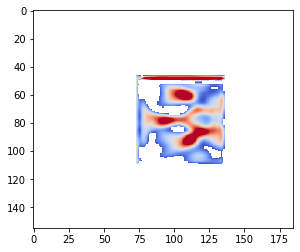

In [79]:
sl = 75
#plt.imshow(1-mni_brain[:,:,sl], cmap='gray')
tmp = hmap_embedding[0,:,:,sl]
hmap_masked = np.ma.array(tmp, mask=tmp<0.1)
plt.imshow(hmap_masked, cmap='coolwarm', alpha=1.0, vmin=0.1, vmax=0.2)
plt.colorbar()
#plt.savefig('Figure4a_foreground.pdf', dpi=600, transparent=False, bbox_inches='tight')

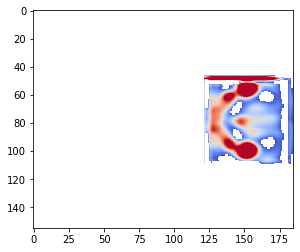

In [84]:
sl = 75
#plt.imshow(1-mni_brain[:,:,sl], cmap='gray')
tmp = hmap_embedding[3,:,:,sl]
hmap_masked = np.ma.array(tmp, mask=tmp<0.1)
plt.imshow(hmap_masked, cmap='coolwarm', alpha=1.0, vmin=0.1, vmax=0.2)
plt.savefig('Figure4b_foreground.pdf', dpi=600, transparent=False, bbox_inches='tight')

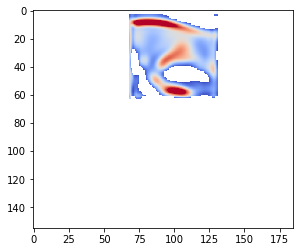

In [91]:
sl = 75
#plt.imshow(1-mni_brain[:,:,sl], cmap='gray')
tmp = hmap_embedding[1,:,:,sl]
hmap_masked = np.ma.array(tmp, mask=tmp<0.1)
plt.imshow(hmap_masked, cmap='coolwarm', alpha=1.0, vmin=0.1, vmax=0.2)
plt.savefig('Figure4d_foreground.pdf', dpi=600, transparent=False, bbox_inches='tight')

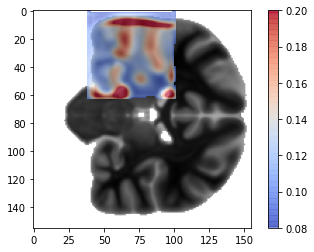

In [390]:
sl = 85
plt.imshow(1-mni_brain[:,sl,:], cmap='gray')
tmp = hmap_embedding[1,:,sl,:]
hmap_masked = np.ma.array(tmp, mask=tmp<0.08)
plt.imshow(hmap_masked, cmap='coolwarm', alpha=0.6, vmin=0.08, vmax=0.2)
plt.colorbar()